# Main



Now some text explaining stuff

## General requirements

In [1]:
from matplotlib.pylab import *
from numpy import *
%matplotlib inline

In [2]:
from Nanorods.sub.subs import *
from matlab.function_EMCCD_CMOS_calib import *

In [3]:
import PIL
import PIL.ExifTags as Exiftags

In [4]:
from matlab.tifmethods import readBigTifFile

In [5]:
windows = False
if windows:
    fname = "C:\\Users\ludwig\Documents\Python data\cell1_BeRST.tif"
else:
    fname = '/mnt/data/Anastasia/sample folder with NR data/image files/cell1_BeRST.tif'
movie = readBigTifFile(fname)
movie = movie.sum(axis=0)

(<Figure size 504x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdfe70594a8>)

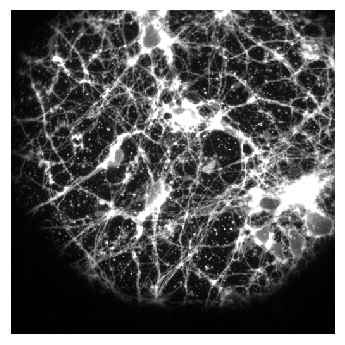

In [6]:
visualization(movie)

In [7]:
if windows:
    folder = r"C:\Users\ludwig\data\NR sample files\18_11_29_pd23_11_div6_WIS_NR-BeRST\image files"
    fname = r"\wave\cell1_1.tif"
    fwave = r"\wave\cell1_1.tif"
    file_Berst='\cell1_BeRST.tif'
    foldercalib = "\EMCCD-CMOS calib\\"
else:
    folder = '/mnt/data/Anastasia/sample folder with NR data/image files/'
    fname = 'wave/cell1_1.tif'
    fwave = 'wave/cell1_1.tif'
    file_Berst='cell1_BeRST.tif'
    foldercalib = "EMCCD-CMOS calib/"


In [8]:
movie = readBigTifFile(folder+fname)
movie = movie.sum(axis=0) # sum(movie,axis=0)

(<Figure size 504x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdfe4fb2898>)

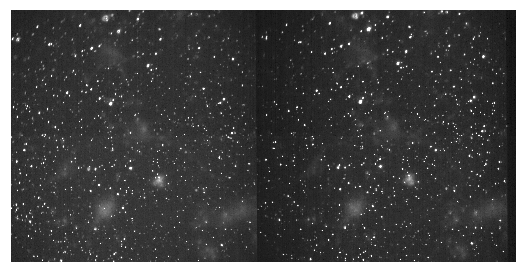

In [9]:
visualization(movie)

##     Mask generation and three fields alignment.

### cMOS camera fields alignment
### EMCCD mask generation
### Transposition of mask two CMOS images


In [10]:
from matlab.function_EMCCD_CMOS_calib import EMCCD_CMOS_calib

In [11]:
#file_wave='\cell1_BeRST.tif'
f=3 #averaging factor for the mask

#EMCCD-CMOS calib results
print(folder+foldercalib)
ax, ay, bx, by = EMCCD_CMOS_calib(folder+foldercalib)

/mnt/data/Anastasia/sample folder with NR data/image files/EMCCD-CMOS calib/


In [12]:
print(ax, ay,bx, by)

0.7910246816347402 0.8152787153028243 74.96592913252292 -33.87204042892071


In [13]:
from matlab.tifmethods import *
info = readtifInfo(folder+file_Berst)
NframesStr = [d for d in info[270].split('\n') if d.find('frames')>=0][0].split('=')[-1]
Nframes = int(NframesStr)
Stim=tile([-60, 0],Nframes//2);

movie = readBigTifFile(folder+file_Berst)
movie_sum = movie.sum(axis=0)
SizeX,SizeY = movie_sum.shape



In [14]:
CorCoef_wave = zeros((SizeX, SizeY))
for x in range(SizeX):
    for y in range(SizeY):
        temp = corrcoef(movie[:,x,y],Stim)
        CorCoef_wave[x,y]=temp[1,0];



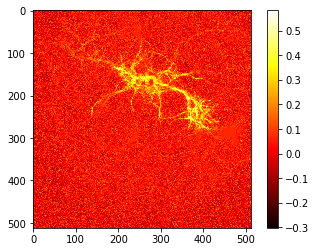

In [15]:
imshow(CorCoef_wave, cmap='hot')
colorbar()

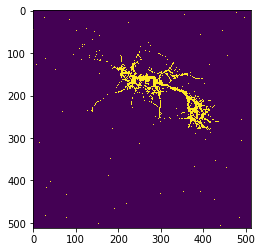

In [16]:
thld=mean(CorCoef_wave)+2.2*std(CorCoef_wave)
Mask_EMCCD=CorCoef_wave*1
Mask_EMCCD[Mask_EMCCD<thld]=0;
Mask_EMCCD[Mask_EMCCD>=thld]=1;
imshow(Mask_EMCCD);

In [17]:
#from matlab.make_mask import movavgy,movavgx

def movavgy (img, wind):
    sizeX, sizeY = img.shape
    imga=img*0
    wind2=wind//2
    for y in range(sizeY):
        for x in range(wind2,sizeX-wind2):
            imga[x,y]=nanmean(img[x-wind2:x+wind2+1,y])
    return imga
def movavgx (img, wind):
    return movavgy(img.transpose(), wind).transpose()


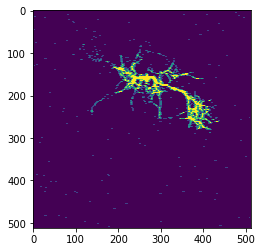

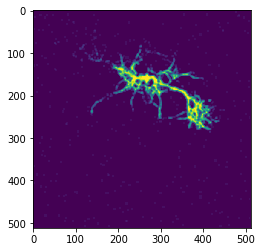

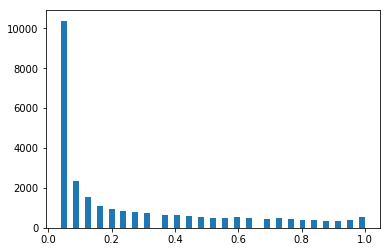

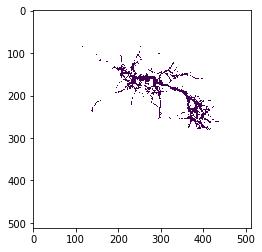

In [18]:
temp1=movavgx (Mask_EMCCD,5);
temp2=movavgy (temp1,5);
imshow(temp1)
figure()
imshow(temp2)
figure()
temp=temp2.flatten()
hist(temp[temp>0],51)
temp3=Mask_EMCCD*1;
temp3[temp2<=0.15]=nan;
temp3[temp3==0]=nan;
figure()
imshow(temp3)

/export/home1/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


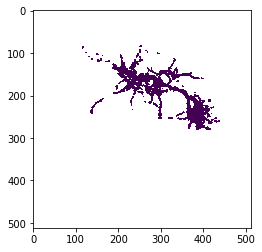

In [19]:
f=3
temp1=movavgx(temp3,f);
Mask_EMCCD_exp=movavgy (temp1,f);
imshow(Mask_EMCCD_exp)

(512, -10)

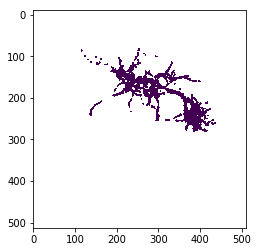

In [20]:
imshow(Mask_EMCCD_exp)
ylim(512,-10)

In [21]:
#import cv2

In [22]:
#from matlab.make_mask import calib

def calib(Mask, ax, ay, bx, by):
    Mask_CMOS=zeros(Mask.shape);
    for Xc in range(Mask_CMOS.shape[1]):
        for Yc in range(Mask_CMOS.shape[0]):
            Xe=int(ax*Xc+bx);
            Ye=int(ay*Yc+by);
            if Xe>-1 and Xe<Mask.shape[1] and Ye>-1 and Ye<Mask.shape[0]:
                Mask_CMOS[Yc,Xc]=Mask[Ye, Xe];
    Mask_CMOS[isnan(Mask_CMOS)]=0
    
    #kernel=2
    #kernelm = cv2.UMat(ones((kernel,kernel),float32)/float(kernel)**2)
    #dilated = cv2.dilate(Mask_CMOS,kernel=kernelm)
    return Mask_CMOS #array(dilated.get())


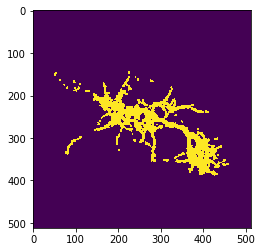

In [23]:
Mask_CMOS=calib(Mask_EMCCD_exp, ax, ay, bx, by)
imshow(Mask_CMOS)

##   Local maxima detection and ROI detection
### Local maxima detection
### Blinking coefficient and selection
### Neural-net?


In [24]:
from matlab.calib import extractpeaks2d0,afintransf, CMOS_2fields_calib

In [25]:
v = CMOS_2fields_calib(folder+foldercalib)

In [26]:
print(v)

[-5.08449093 -2.96550568]


In [27]:
calibim = readtifImage(folder+foldercalib+'calib_CMOS_2.tif')

In [28]:
ptsB = extractpeaks2d0(calibim[:,:512])

(<Figure size 504x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdfe4e0b940>)

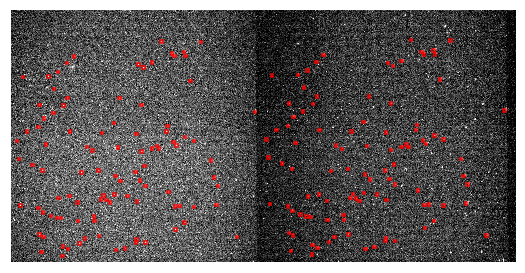

In [29]:
ptsR2 = 1.0*ptsB
ptsR2[:,0] += 512+v[0]
ptsR2[:,1] += v[1]
visualization(calibim,row_stack((ptsB[:100,:],ptsR2[:100,:])))

In [30]:
dx, dy = 512+v[0],v[1]

In [31]:
#folder = r"C:\Users\ludwig\data\NR sample files\18_11_29_pd23_11_div6_WIS_NR-BeRST\image files"
fname = fwave
movie = readBigTifFile(folder+fname)
movie_sum = movie.sum(axis=0) # sum(movie,axis=0)


In [32]:
info = readtifInfo(folder+fname)
NframesStr = [d for d in info[270].split('\n') if d.find('frames')>=0][0].split('=')[-1]
Nframes = int(NframesStr)

In [33]:
TacqStr = [d for d in info[270].split('\n') if d.find('finterval')>=0][0].split('=')[-1]
Tacq = float(TacqStr)


In [34]:
# Generating stimulation trace
Stim=tile([0, 0, -60, -60],Nframes//4);

(<Figure size 504x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdfe4e224a8>)

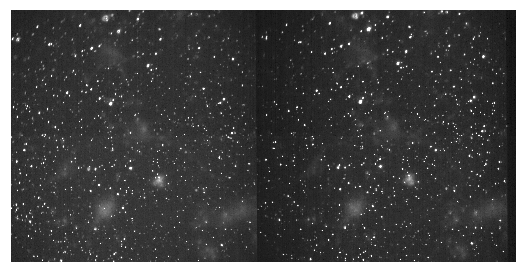

In [35]:
visualization(movie_sum)

In [36]:
kernel = 5
ROIsize=5
km = ones((kernel,kernel),float32)#/float(kernel)**2
J = zeros(Mask_CMOS.shape)
rs2 = kernel//2
mx,my = Mask_CMOS.shape

for x in range(0,mx-kernel):
    for y in range(0,my-kernel):
        temp = km*movie_sum[x:(x+kernel),y:(y+kernel)]
        J[x+rs2,y+rs2] = temp.max()

In [37]:
mx,my = Mask_CMOS.shape
pts = [] 
for x in range(2*ROIsize+1,mx-2*ROIsize):
    for y in range(2*ROIsize,my-2*ROIsize):
        if Mask_CMOS[x,y]>0 and J[x, y]==movie_sum[x, y]:
            pts.append([y, x])


pts = array(pts)

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdfe3155550>)

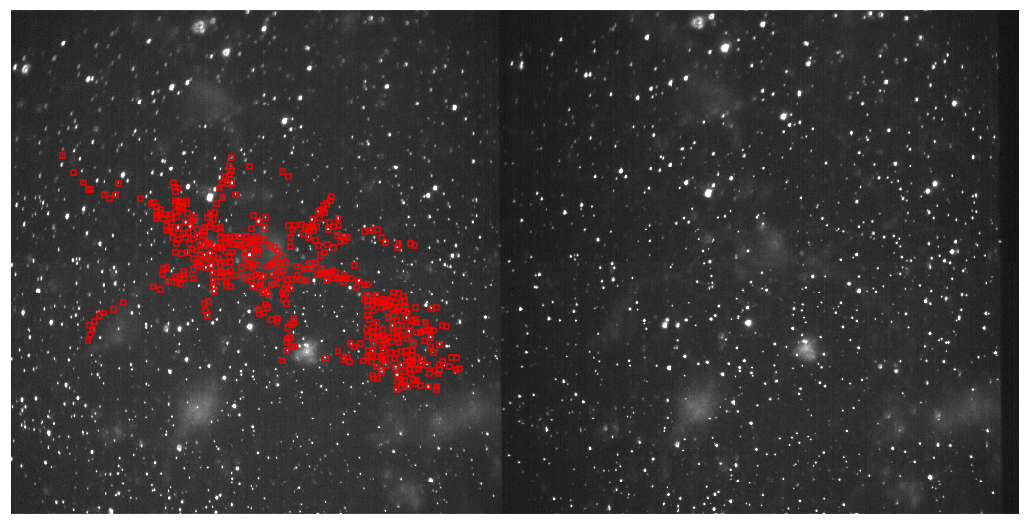

In [38]:
visualization(movie_sum,pts,figsize=(14,14))

In [39]:
x=pts[:,0]+dx
y=pts[:,1]+dy

In [40]:
sel = x+floor(ROIsize/2)<movie_sum.shape[1]
sel = sel*(y+floor(ROIsize/2)<movie_sum.shape[0])
sel = sel*(y-floor(ROIsize/2)>0)
x = x[sel]
y = y[sel]

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdfe30349b0>)

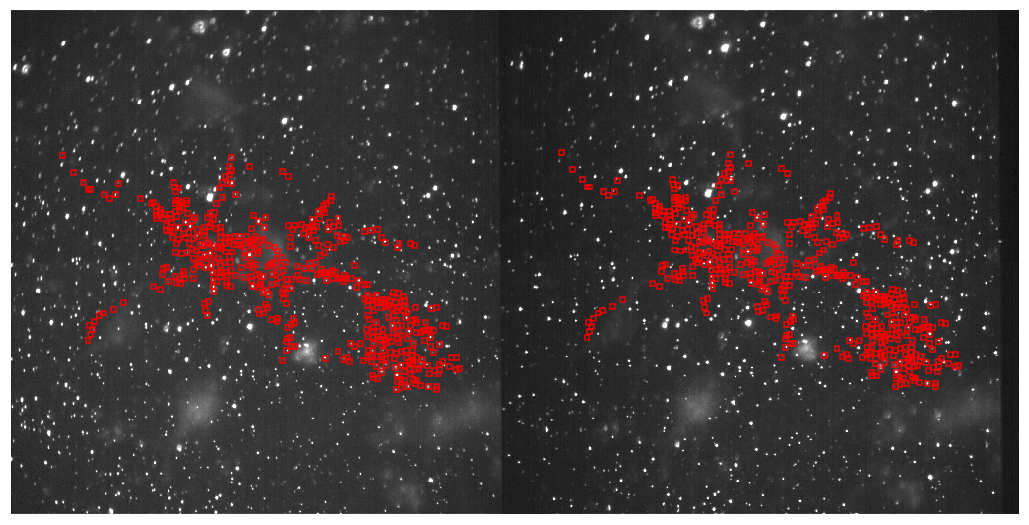

In [41]:
ptsr=column_stack((x,y))
ptsb=pts*1
pts_all=row_stack((ptsb,ptsr))
visualization(movie_sum,pts_all,figsize=(14,14))

##   Processing ROIs:
### Linearization of ROI
### Blinking substraction
### Stitching cycles
### Mobility



##    Extracting Signal
### FT score calculation
### Interval extraction



##   Bootstrap?

